In [1]:
import os
from os.path import join, abspath

import sys
sys.path.append(abspath('..'))
import pandas as pd
import numpy as np

from utils import get_dataset, get_target, Preprocessor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from warnings import simplefilter
simplefilter("ignore")

RANDOM_STATE = 25
np.random.seed(RANDOM_STATE)


DATA_PATH = join(os.getcwd(), '..', 'data', 'events')

## 1. Load Dataset

In [2]:
event_keys = os.listdir(DATA_PATH)
event_keys = [ek for ek in event_keys if ek.isdigit()]
event_dirs = [join(DATA_PATH, ek) for ek in event_keys]
len(event_dirs)

5

In [3]:
teams, players = get_dataset(event_dirs)
teams = teams.dropna()
players = players.dropna()

Player with id=15573 has no matching team_id.
Player with id=16848 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=21816 has no matching team_id.
Player with id=18163 has no matching team_id.
Player with id=21217 has no matching team_id.
Player with id=13618 has no matching team_id.
Player with id=20170 has no matching team_id.
Player with id=13602 has no matching team_id.
Player with id=11777 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=19164 has no matching team_id.


In [4]:
teams

,has_roster_change,world_ranking,points,avg_place,winrate,avg_match_intensity,avg_win_intensity,avg_loss_intensity,winstreak,matches_played,...,wr,team_id,team_name,is_lan,is_qual,prize_pool,start_at,ends_at,duration,event_id
0,False,20,117,4.87500,0.619048,1.160991,1.434571,0.716424,4,21,...,1.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
1,False,20,117,4.80000,0.512821,1.373098,2.027451,0.684306,0,39,...,1.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
2,True,20,117,5.28125,0.591837,1.453861,1.989617,0.677014,0,49,...,1.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
3,False,20,117,4.87500,0.500000,1.062761,1.409098,0.716424,2,16,...,1.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
4,False,20,117,14.50000,0.600000,0.977839,1.183785,0.668919,1,5,...,1.000000,12394,betboom,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,False,3,709,3.50000,0.500000,1.106838,1.444444,0.769231,0,2,...,0.333333,9565,vitality,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
476,False,3,709,3.75000,0.500000,1.394595,2.022222,0.766968,0,4,...,0.333333,9565,vitality,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
477,False,3,709,9.00000,0.250000,1.010977,1.444444,0.866488,0,4,...,0.333333,9565,vitality,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
478,False,3,709,3.75000,0.500000,1.394595,2.022222,0.766968,0,4,...,0.333333,9565,vitality,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148


In [5]:
players

,rating,dpr,kast,impact,adr,kpr,total_kills,hs,kd,gdr,...,player_name,expected_pts,player_id,is_lan,is_qual,prize_pool,start_at,ends_at,duration,event_id
0,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.0,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
1,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.0,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
2,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.0,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
3,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.0,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
4,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,fl1t,4.0,12732,True,False,500000.0,2024-05-14 00:00:00,2024-05-19 00:00:00,5,7755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36783,1.15,0.67,73.2,1.30,80.4,0.70,395,56.5,1.03,6.5,...,brollan,11.75,13666,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
36784,1.15,0.67,73.2,1.30,80.4,0.70,395,56.5,1.03,6.5,...,brollan,11.75,13666,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
36785,1.15,0.67,73.2,1.30,80.4,0.70,395,56.5,1.03,6.5,...,brollan,11.75,13666,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148
36786,1.15,0.67,73.2,1.30,80.4,0.70,395,56.5,1.03,6.5,...,brollan,11.75,13666,True,False,1250000.0,2024-03-21 00:00:00,2024-03-31 00:00:00,10,7148


In [6]:
len(teams), len(players)

(427, 32708)

## 2. Modelling

In [7]:
event_keys

['7755', '7440', '7437', '6976', '7148']

In [8]:
train_events = [7755, 7440, 7437, 6976]
test_events = [int(ek) for ek in event_keys if int(ek) not in train_events]

### 2.1. Teams model

In [9]:
target_col = ["wr"]

drop_cols = ["start_time", "end_time", "start_at", "ends_at", "event_id", "team_id",
             "event_fil", "team_name"]
drop_cols += [f"player_id_{i + 1}" for i in range(5)]
drop_cols += target_col

cat_cols = ["ranking_fil"]
bin_cols = ["has_roster_change", "is_lan", "is_qual"]

teams[bin_cols] = teams[bin_cols].astype(np.float64)
teams[target_col] = teams[target_col].astype(np.float64)

In [10]:
train = teams[teams.event_id.isin(train_events)].sample(frac=1).reset_index(drop=True)
test = teams[teams.event_id.isin(test_events)].sample(frac=1).reset_index(drop=True)

X_train, y_train = train.drop(drop_cols, axis=1), train[target_col]
X_test, y_test = test.drop(drop_cols, axis=1), test[target_col]

In [11]:
len(X_train), len(X_train.columns)

(331, 15)

In [12]:
team_pipe = Pipeline([
    ("preprocessor", Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)),
    ("estimator", Ridge(alpha=10))
])

In [13]:
team_pipe.fit(X_train, y_train)
y_preds = team_pipe.predict(X_test)
y_preds = (y_preds - y_preds.min()) / (y_preds.max() - y_preds.min())
mean_squared_error(y_test, y_preds)

0.033578124118447766

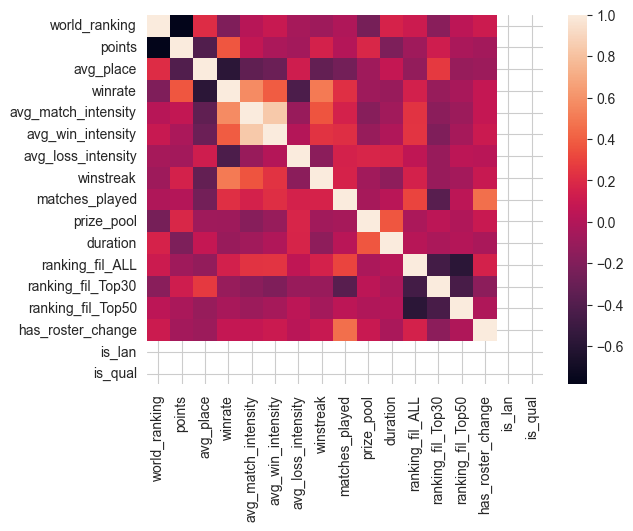

In [14]:
p = Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)
p.fit(X_train, y_train)
X_train_prep = p.transform(X_train)

sns.heatmap(X_train_prep.corr());

In [15]:
n = 10

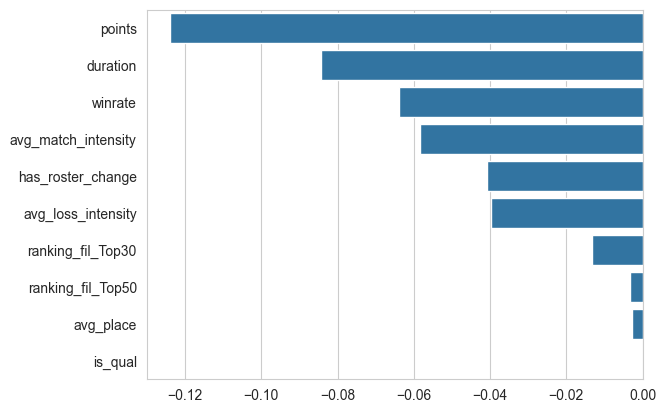

In [16]:
idx = np.argsort(team_pipe["estimator"].coef_.ravel())[:n]
sns.barplot(x=team_pipe["estimator"].coef_.ravel()[idx],
            y=team_pipe["preprocessor"].features.ravel()[idx]);

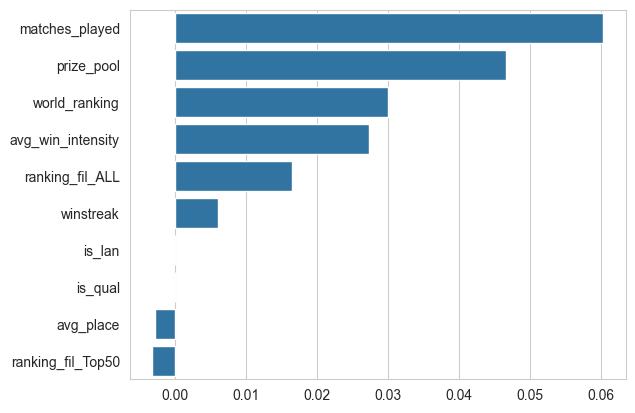

In [17]:
idx = np.argsort(team_pipe["estimator"].coef_.ravel())[::-1][:n]
sns.barplot(x=team_pipe["estimator"].coef_.ravel()[idx],
            y=team_pipe["preprocessor"].features.ravel()[idx]);

По реальному винрейту:

In [18]:
final_team = test[["team_id", "team_name"]]
final_team["wr"] = y_test
final_team["pred_wr"] = y_preds
final_team = final_team.groupby(["team_id"]).max()
final_team = final_team.sort_values(["wr"], ascending=False)
final_team

,team_name,wr,pred_wr
team_id,,,
6248,the-mongolz,1.000000,0.968241
8297,furia,1.000000,0.931420
7175,heroic,0.750000,0.838995
9455,imperial,0.750000,0.965541
11419,ecstatic,0.750000,1.000000
4773,pain,0.600000,0.987810
5005,complexity,0.600000,0.711455
5378,virtuspro,0.600000,0.898013
5995,g2,0.428571,0.511000


По предсказанному винрейту (маппинг в $[0, 1]$, минмакс):

In [19]:
final_team.sort_values(["pred_wr"], ascending=False)

,team_name,wr,pred_wr
team_id,,,
11419,ecstatic,0.750000,1.000000
4773,pain,0.600000,0.987810
6248,the-mongolz,1.000000,0.968241
9455,imperial,0.750000,0.965541
8297,furia,1.000000,0.931420
5378,virtuspro,0.600000,0.898013
7175,heroic,0.750000,0.838995
5005,complexity,0.600000,0.711455
5752,cloud9,0.400000,0.686104


### Замечание

Без минмакс маппинга результаты ранжирования другие.

### 2.2. Players model

In [20]:
target_col = ["expected_pts"]

drop_cols = ["start_time", "end_time", "start_at", "ends_at", "event_id", "player_id",
             "player_name",
             "duration", "maps_played", "kpr"]  # correlated
drop_cols += [f"team_id"]
drop_cols += target_col

cat_cols = ["event_fil", "ranking_fil"]
bin_cols = ["is_lan", "is_qual", "is_awp"]

players[bin_cols] = players[bin_cols].astype(np.float64)
players[target_col] = players[target_col].astype(np.float64)
players = players.dropna()

In [21]:
train = players[players.event_id.isin(train_events)].sample(frac=1).reset_index(drop=True)
test = players[players.event_id.isin(test_events)].sample(frac=1).reset_index(drop=True)

X_train, y_train = train.drop(drop_cols, axis=1), train[target_col].astype(np.float64)
X_test, y_test = test.drop(drop_cols, axis=1), test[target_col].astype(np.float64)

In [22]:
len(X_train), len(X_train.columns)

(24429, 20)

In [23]:
player_pipeline = Pipeline([
    ("preprocessor", Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)),
    ("estimator", Ridge(alpha=1))
])

In [24]:
player_pipeline.fit(X_train, y_train)
y_preds = player_pipeline.predict(X_test)
mean_squared_error(y_test, y_preds)

32.94090133413917

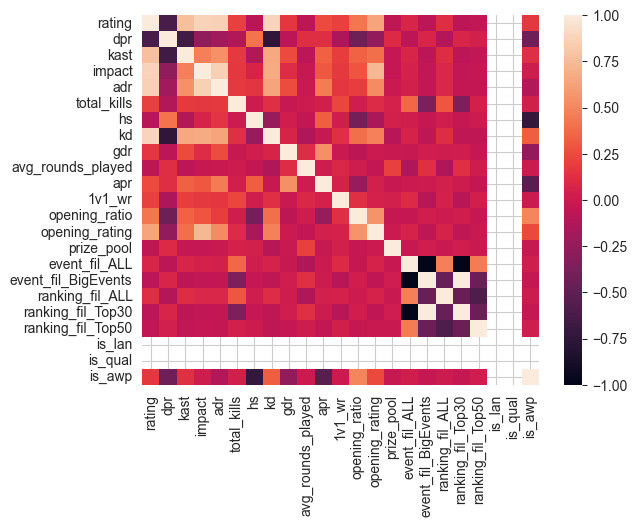

In [25]:
p = Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)
p.fit(X_train, y_train)
X_train_prep = p.transform(X_train)

sns.heatmap(X_train_prep.corr());

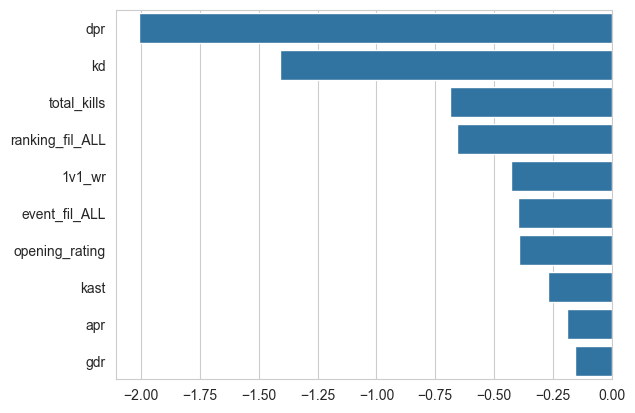

In [26]:
idx = np.argsort(player_pipeline["estimator"].coef_.ravel())[:n]
sns.barplot(x=player_pipeline["estimator"].coef_.ravel()[idx],
            y=player_pipeline["preprocessor"].features.ravel()[idx]);

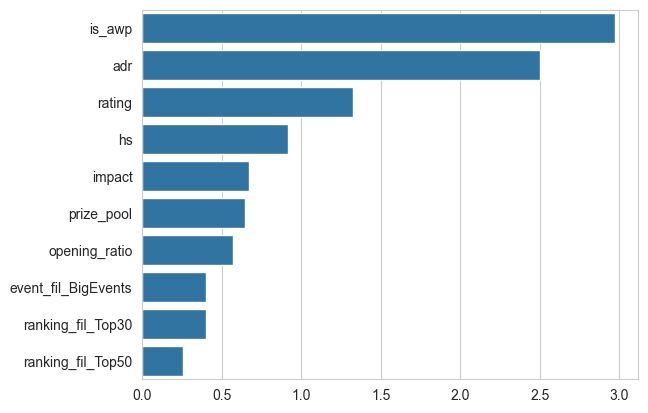

In [27]:
idx = np.argsort(player_pipeline["estimator"].coef_.ravel())[::-1][:n]
sns.barplot(x=player_pipeline["estimator"].coef_.ravel()[idx],
            y=player_pipeline["preprocessor"].features.ravel()[idx]);

Обычная регрессия выдавала взрывные коэффициенты на фильтры.

По реальным поинтам:

In [28]:
final_player = test[["player_id", "team_id", "player_name"]]
final_player[["player_id", "team_id"]] = final_player[["player_id", "team_id"]].astype(np.int32)
final_player["pts"] = y_test
final_player["pred_pts"] = y_preds
final_player = final_player.groupby(["player_id"]).max()
final_player = final_player.sort_values(["pts"], ascending=False)
final_player

,team_id,player_name,pts,pred_pts
player_id,,,,
21167,7020,donk,16.750000,26.485106
19230,5995,m0nesy,15.000000,17.489216
18072,4494,torzsi,13.000000,11.034981
13666,4494,brollan,11.750000,14.451618
18850,4494,jimpphat,11.000000,11.802926
...,...,...,...,...
16820,4494,siuhy,-5.250000,5.502168
21379,11419,salazar,-6.750000,4.689061
12521,8297,art,-7.000000,4.171939


По предсказанным поинтам:

In [29]:
final_player.sort_values(["pred_pts"], ascending=False)

,team_id,player_name,pts,pred_pts
player_id,,,,
21167,7020,donk,16.750,26.485106
8738,5005,elige,0.000,21.325515
16920,7020,sh1ro,11.000,19.882138
13776,5378,jame,7.200,17.911860
19230,5995,m0nesy,15.000,17.489216
...,...,...,...,...
429,6667,karrigan,-2.250,1.533983
13749,11419,queenix,-2.750,0.711643
9816,4608,aleksib,-7.375,0.283502


## 3. Results

По реальному таргету:

In [30]:
final = final_player.join(final_team, on="team_id")
final["target"] = get_target(final.pts, final.wr)
final["pred_target"] = get_target(final.pred_pts, final.pred_wr)
final = final[["target", "pred_target", "team_name", "player_name"]]
final = final.sort_values(["target"], ascending=False)
final

,target,pred_target,team_name,player_name
player_id,,,,
21167,16.000000,25.557950,spirit,donk
19230,15.857143,19.088216,g2,m0nesy
18072,12.250000,12.188624,mouz,torzsi
13666,11.000000,15.605260,mouz,brollan
16555,10.800000,20.478294,cloud9,ax1le
...,...,...,...,...
10566,-2.666667,9.251123,furia,chelo
21379,-3.000000,10.689061,ecstatic,salazar
14759,-5.750000,6.047581,natus-vincere,im


По предсказанному таргету:

In [31]:
final = final.sort_values(["pred_target"], ascending=False)
final

,target,pred_target,team_name,player_name
player_id,,,,
21167,16.000000,25.557950,spirit,donk
8738,2.400000,24.728606,complexity,elige
13776,9.600000,22.993975,virtuspro,jame
16555,10.800000,20.478294,cloud9,ax1le
16947,4.000000,20.450936,cloud9,perfecto
...,...,...,...,...
150,6.400000,2.899563,eternal-fire,maj3r
18462,2.333333,2.720608,vitality,mezii
7716,0.750000,2.660176,spirit,chopper


## Замечение

Без маппинга винрейта в $[0, 1]$ превалирует таргет чисто по командам. Пока слабые результаты.